# Data Analysis

The notebook details the process of EDA and analysis of the merged datasets.

## Content (Visuals)
- heat map showing spearman(?) correlation
- bivariate Geographical map showing mh score and some impactful environmental feature at either the state or division
level, with indicators for states that have few rows in our cleaned dataset
- mental health scores for our city comparisons
- Maybe a pairplot(?) showing correlations between features but we need to decide which <10 features to include in that pairplot

## Cities with similar environmental features
visual will be multi subplots choropleth map that presenting their `mh_score`.

In [1]:
import map_module as map
import file_path as path


import numpy as np
import matplotlib.pyplot as plt

In [2]:
# combine city_geo_file and merged_data_file
geo_data = path.geo_us_file
merged_data = path.merged_data_file

mh_score_df, _ = map.df_manipulation_for_bimap(geo_data, merged_data, 'Longitude',other_features = ['State','Urban Center'], lefton='UC_Grouping', righton='UC_Grouping',mh_feature='MH_Score', percentile = np.linspace(0.33, 1, 3), color_list=['#ffb000', '#dc267f', '#648fff', '#785ef0'],
    env_color_01 = 'c1_env',
    mh_col = 'MH_Score',
    mh_color_02 = 'c2_mh')


In [3]:
print(type(mh_score_df))
mh_score_df.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,MH_Score,Longitude,State,Urban Center,c1_env,c2_mh
0,"MULTIPOLYGON (((-158.01244 21.42219, -157.9915...",0.052083,0.000000,HI,Honolulu,2,2
1,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411...",0.656250,0.427609,CA,Santa Maria,1,1


In [5]:
# create color list for ledgend
c_lst = map.mono_mikhailsirenko_colorscale(
    percentile = np.linspace(0.2, 1, 5),
    color_list=['#0000FF', '#FF0000']
)

In [7]:
color_df = map.mono_assign_color_cells(mh_score_df, mh_col = 'MH_Score', mh_color_02 = 'mh_color', percentile=np.linspace(0.2, 1, 5))
color_df.sample(3)

,geometry,MH_Score,Longitude,State,Urban Center,c1_env,c2_mh,mh_color
47,"MULTIPOLYGON (((-106.79199 32.36148, -106.7809...",0.395833,0.583596,NM,Las Cruces,1,1,3
170,"MULTIPOLYGON (((-84.20589 39.85334, -84.19413 ...",0.822917,0.841427,OH,Dayton,0,0,0
174,"MULTIPOLYGON (((-85.59507 42.31970, -85.58303 ...",0.583333,0.825403,MI,Kalamazoo,0,1,2


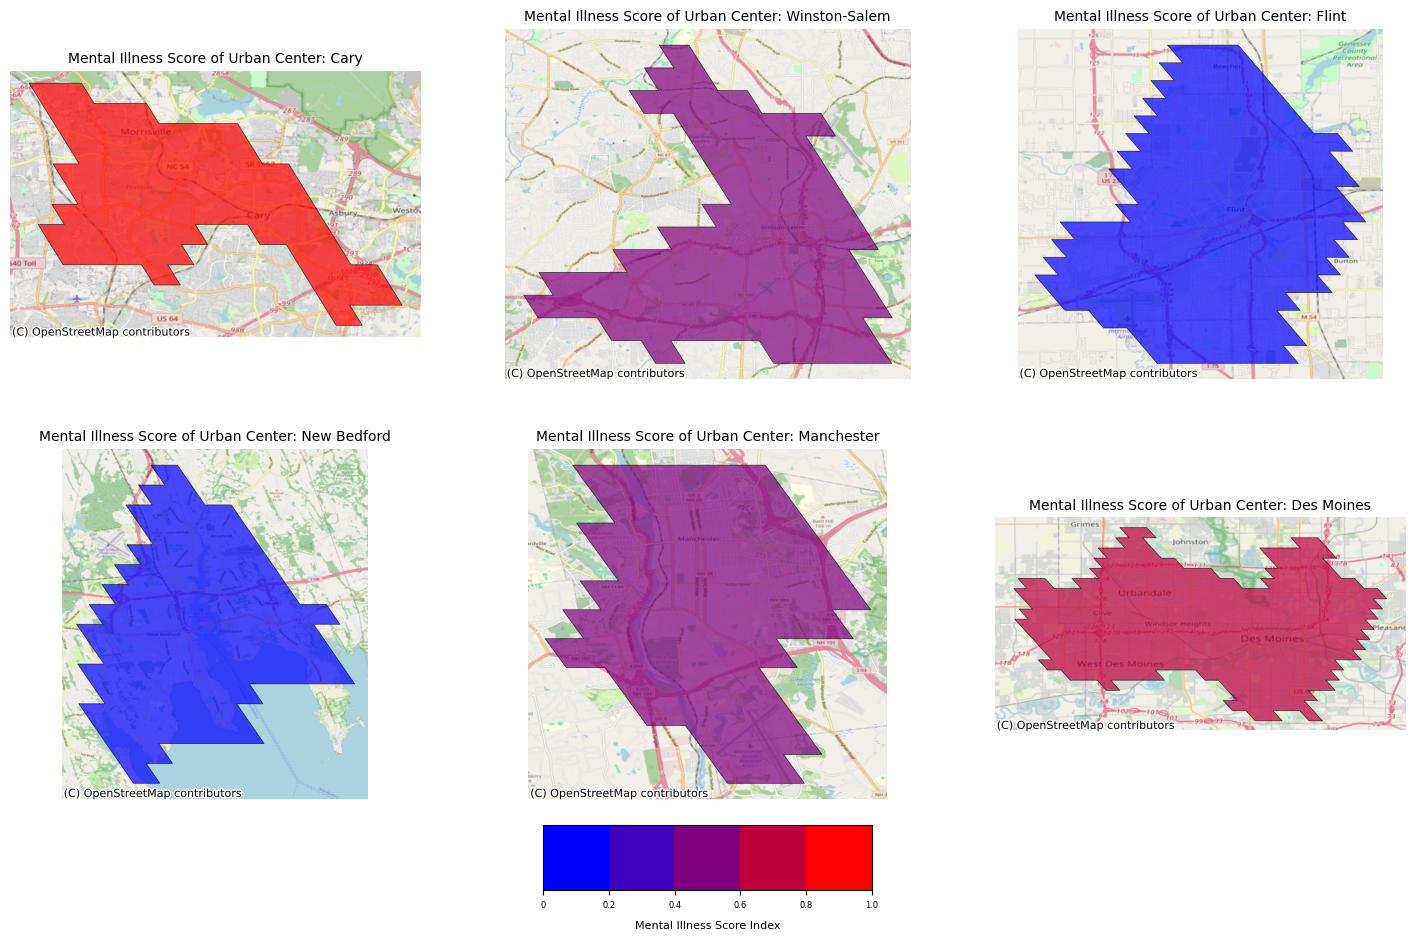

In [11]:
fig,ax = plt.subplots(2,3,figsize=(18,10))
map.map_urban_center(color_df, ax[0,0], 'Cary', c_lst,alpha=0.7,mh_color_02 = 'mh_color',filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map.map_urban_center(color_df, ax[0,1], 'Winston-Salem', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map.map_urban_center(color_df, ax[0,2], 'Flint', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map.map_urban_center(color_df, ax[1,0], 'New Bedford', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map.map_urban_center(color_df, ax[1,1], 'Manchester', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)
map.map_urban_center(color_df, ax[1,2], 'Des Moines', c_lst,alpha=0.7,mh_color_02 = 'mh_color',
filter_col = 'Urban Center',edgecolor='black', linewidth=0.5)

map.set_off_axis(ax[0,0])
map.set_off_axis(ax[0,1])
map.set_off_axis(ax[0,2])
map.set_off_axis(ax[1,0])
map.set_off_axis(ax[1,1])
map.set_off_axis(ax[1,2])


ax[0,0].set_title('Mental Illness Score of Urban Center: Cary', fontsize=10)
ax[0,1].set_title('Mental Illness Score of Urban Center: Winston-Salem', fontsize=10)
ax[0,2].set_title('Mental Illness Score of Urban Center: Flint', fontsize=10)
ax[1,0].set_title('Mental Illness Score of Urban Center: New Bedford', fontsize=10)
ax[1,1].set_title('Mental Illness Score of Urban Center: Manchester', fontsize=10)
_= ax[1,2].set_title('Mental Illness Score of Urban Center: Des Moines', fontsize=10)



map.mono_color_legend(ax[1,2],c_lst,percentile = np.linspace(0.2, 1, 5),
    legend_position=[-1.1, -1, 0.8, 0.8],
    tick_fontsize=6,
    label_fontsize=8,
    title = 'Mental Illness Score Index',    
)